In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/drive/MyDrive/kaggle_dataset

/content/drive/MyDrive/kaggle_dataset


In [ ]:
!ls

face-recognition  kaggle.json


To load face images

In [ ]:
!kaggle datasets download -d kasikrit/att-database-of-faces

In [ ]:
!mkdir face-recognition
!mv att-database-of-faces.zip face-recognition

In [ ]:
%cd face-recognition/

In [ ]:
!unzip att-database-of-faces.zip

To load natural images

In [ ]:
!kaggle datasets download -d prasunroy/natural-images

natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir non-face-images
!mv natural-images.zip non-face-images

In [ ]:
%cd non-face-images/

/content/drive/MyDrive/kaggle_dataset/non-face-images


In [ ]:
!unzip natural-images.zip

# **Imports**

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
from numpy import asarray
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

# **Generate Data Matrix and Label vector**

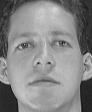

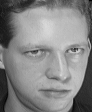

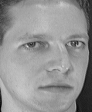

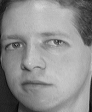

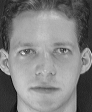

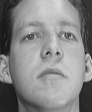

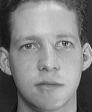

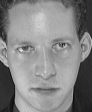

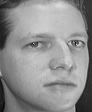

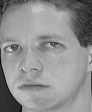

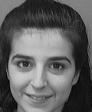

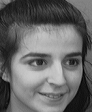

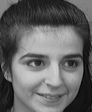

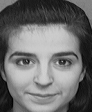

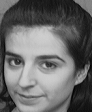

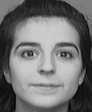

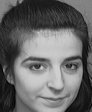

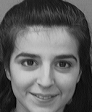

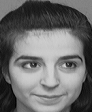

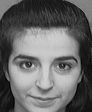

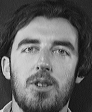

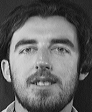

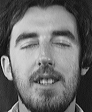

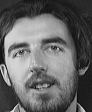

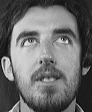

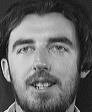

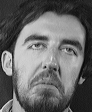

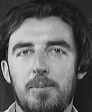

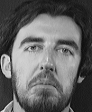

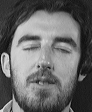

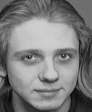

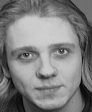

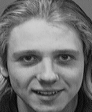

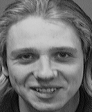

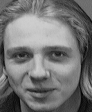

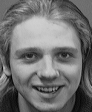

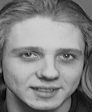

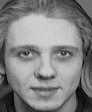

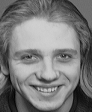

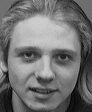

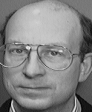

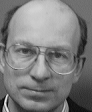

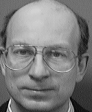

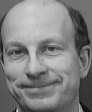

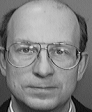

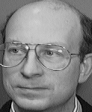

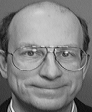

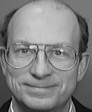

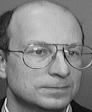

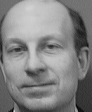

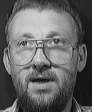

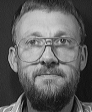

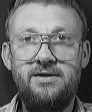

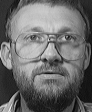

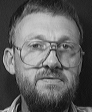

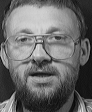

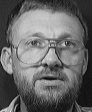

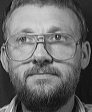

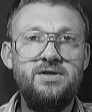

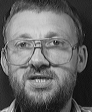

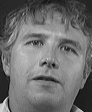

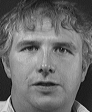

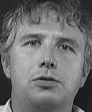

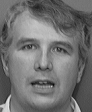

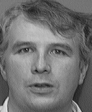

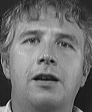

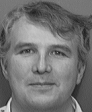

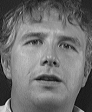

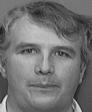

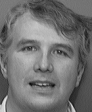

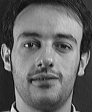

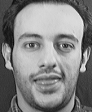

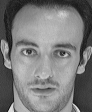

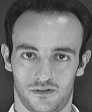

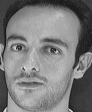

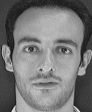

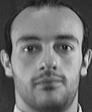

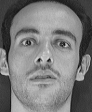

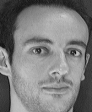

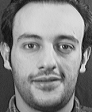

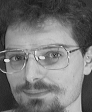

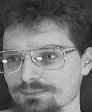

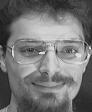

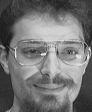

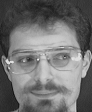

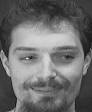

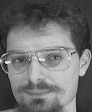

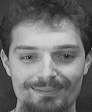

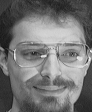

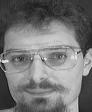

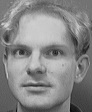

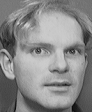

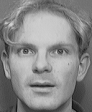

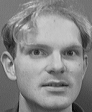

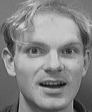

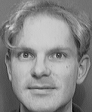

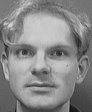

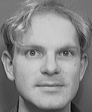

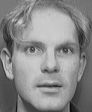

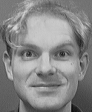

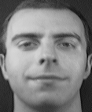

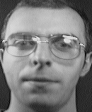

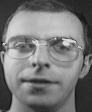

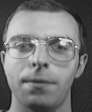

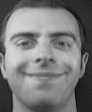

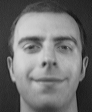

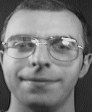

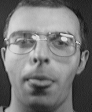

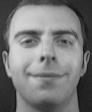

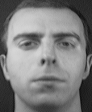

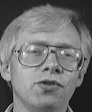

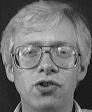

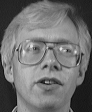

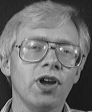

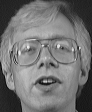

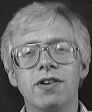

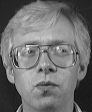

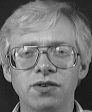

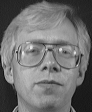

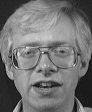

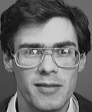

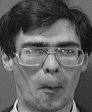

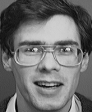

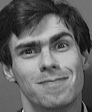

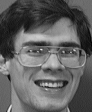

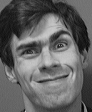

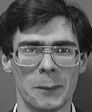

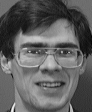

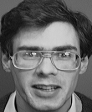

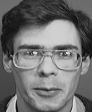

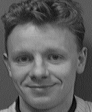

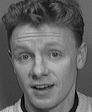

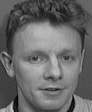

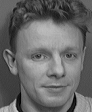

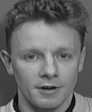

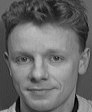

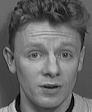

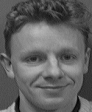

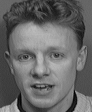

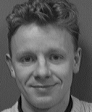

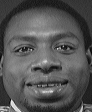

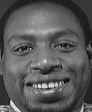

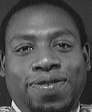

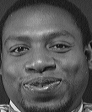

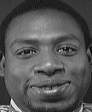

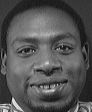

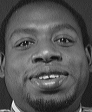

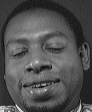

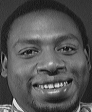

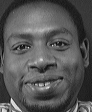

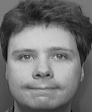

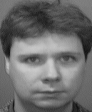

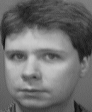

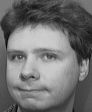

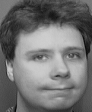

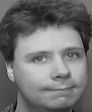

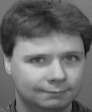

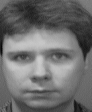

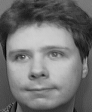

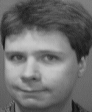

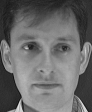

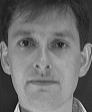

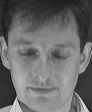

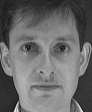

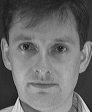

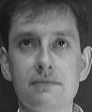

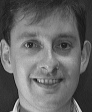

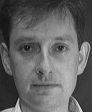

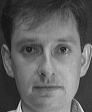

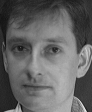

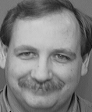

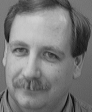

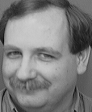

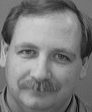

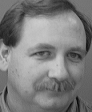

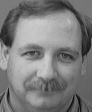

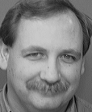

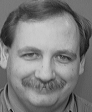

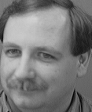

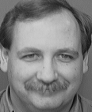

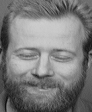

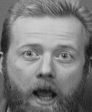

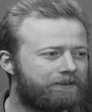

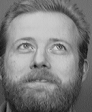

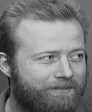

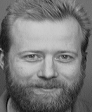

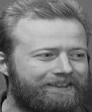

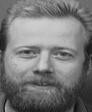

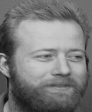

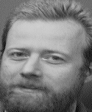

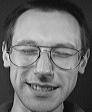

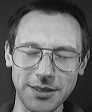

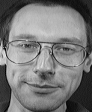

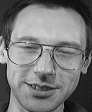

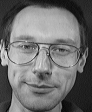

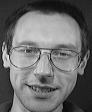

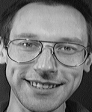

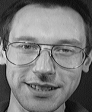

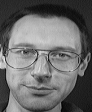

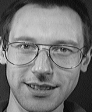

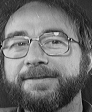

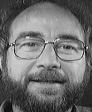

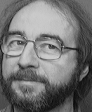

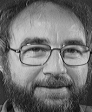

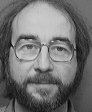

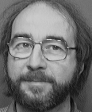

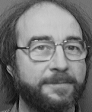

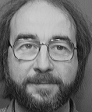

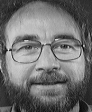

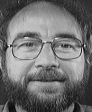

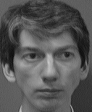

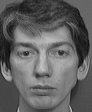

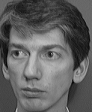

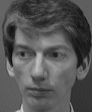

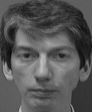

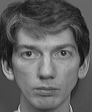

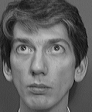

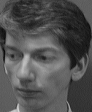

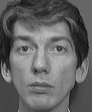

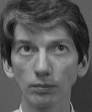

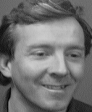

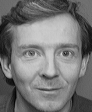

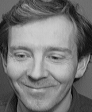

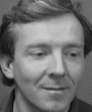

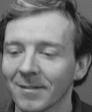

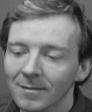

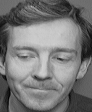

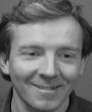

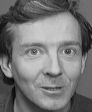

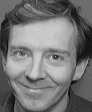

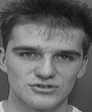

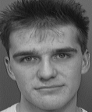

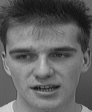

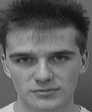

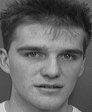

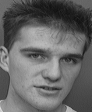

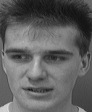

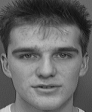

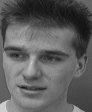

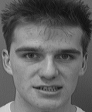

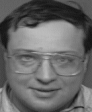

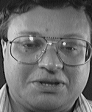

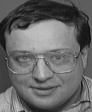

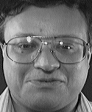

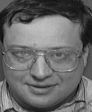

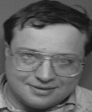

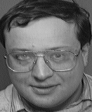

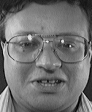

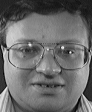

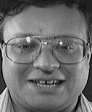

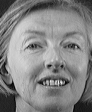

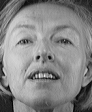

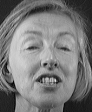

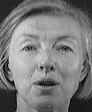

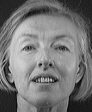

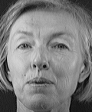

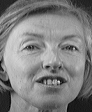

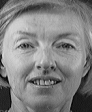

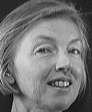

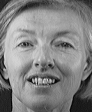

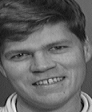

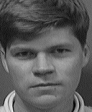

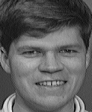

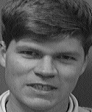

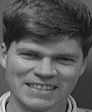

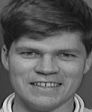

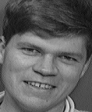

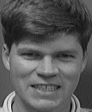

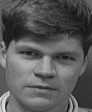

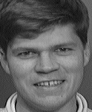

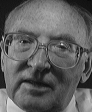

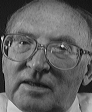

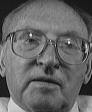

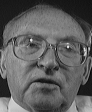

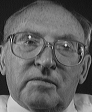

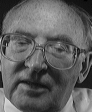

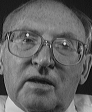

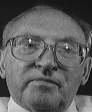

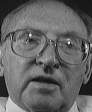

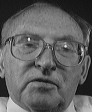

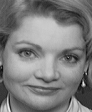

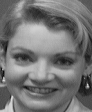

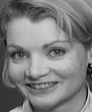

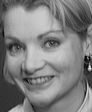

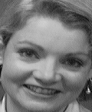

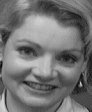

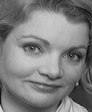

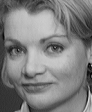

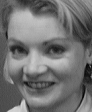

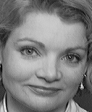

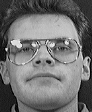

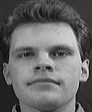

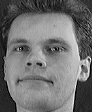

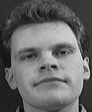

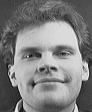

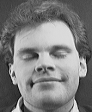

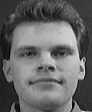

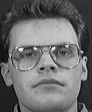

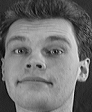

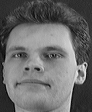

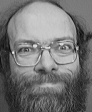

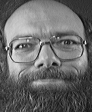

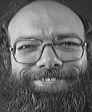

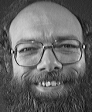

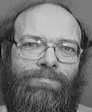

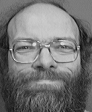

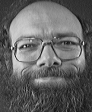

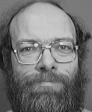

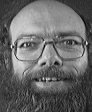

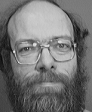

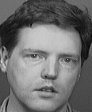

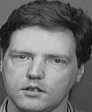

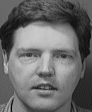

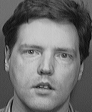

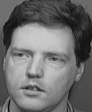

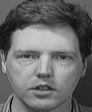

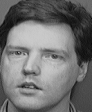

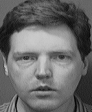

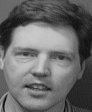

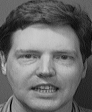

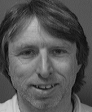

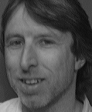

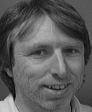

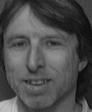

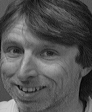

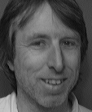

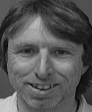

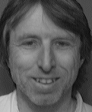

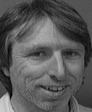

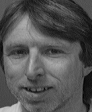

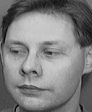

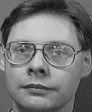

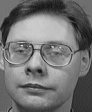

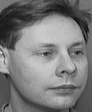

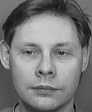

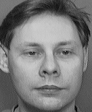

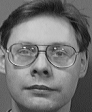

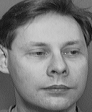

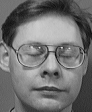

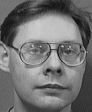

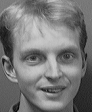

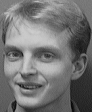

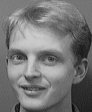

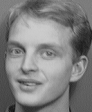

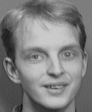

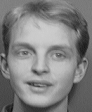

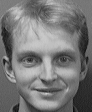

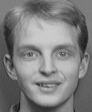

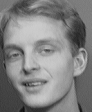

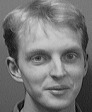

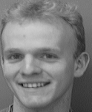

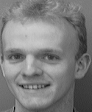

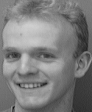

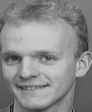

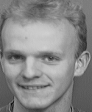

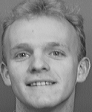

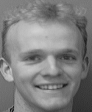

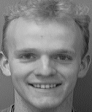

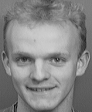

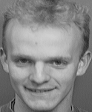

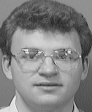

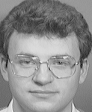

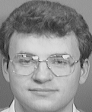

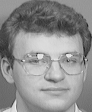

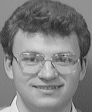

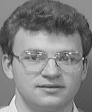

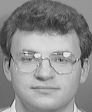

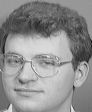

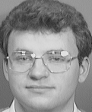

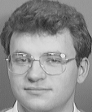

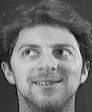

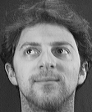

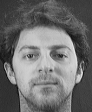

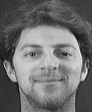

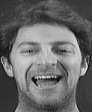

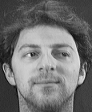

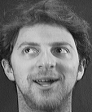

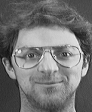

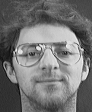

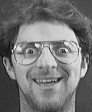

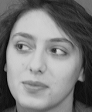

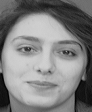

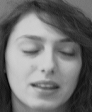

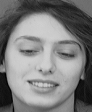

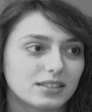

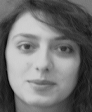

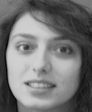

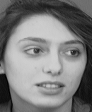

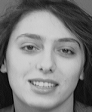

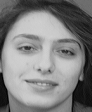

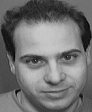

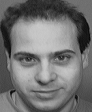

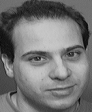

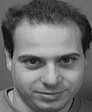

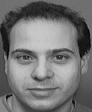

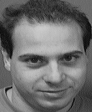

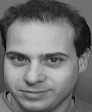

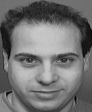

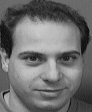

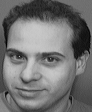

In [ ]:
D=np.empty((0,10304),dtype=int)
Y=np.empty((0,1),dtype=int)

path='/content/drive/MyDrive/kaggle_dataset/face-recognition'
for foldername in os.listdir(path):
  folderpath=os.path.join(path,foldername)
  if foldername.startswith("s"):
    for pic in os.listdir(folderpath):
      img=cv2.imread(os.path.join(folderpath,pic),0)
      cv2_imshow(img)
      data = asarray(img).flatten()
      D=np.vstack((D,data))
      label = int("".join(filter(str.isdigit, foldername)));
      Y=np.vstack((Y,label))
  

# **Split the Dataset into Training and Test sets**

In [ ]:
D_train = D[::2, :]
Y_train = Y[::2, :]
D_test = D[1::2, :]
Y_test = Y[1::2, :]

print(D_train.shape)
print(Y_train.shape)
print(D_test.shape)
print(Y_test.shape)

(200, 10304)
(200, 1)
(200, 10304)
(200, 1)


# **PCA**

In [ ]:
def pca(D_train,Y_train,D_test,Y_test,alpha):
  #compute mean
  mean = np.mean(D_train , axis = 0)

  #center the data
  Z=D_train-mean

  #compute covariance matrix
  rows, columns = D_train.shape
  cov = (1/rows)*np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(cov)
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  trainnig_accuracy=[]
  test_accuracy=[]
  #for every alpha
  for a in alpha:
    print("Alpha: "+str(a))
    #compute the fraction of total variance and choose dimentionality
    sum_lamda=0
    no_of_components=0
    total_lamda=sum(sorted_eigenvalue)
    for i in range(len(sorted_eigenvalue)) :
      sum_lamda=sum_lamda+sorted_eigenvalue[i]
      fraction = sum_lamda/total_lamda
      if(fraction>=a):
        no_of_components=i+1
        break

    print("No.of components"+str(no_of_components))
    #projection matrix
    P=sorted_eigenvectors[:,0:no_of_components]
    print("shape of Projection matrix"+str(P.shape))

    #Project the training set, and test sets
    reduced_D_train = np.dot(D_train,P)
    reduced_D_test = np.dot(D_test,P)

    #K-NN
    skf = StratifiedKFold(n_splits=5)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(reduced_D_train, np.ravel(Y_train))
    #training_acc = knn.score(reduced_D_train,  np.ravel(Y_train))
    scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
    training_acc = scores.mean()
    test_acc = knn.score(reduced_D_test, np.ravel(Y_test))
    print("Validation Accuracy: "+str(training_acc))
    print("Testing Accuracy: "+str(test_acc))

    trainnig_accuracy.append(training_acc)
    test_accuracy.append(test_acc)


  return trainnig_accuracy , test_accuracy

# Report Accuracy for every value of alpha

Alpha: 0.8
No.of components37
shape of Projection matrix(10304, 37)
Validation Accuracy: 0.9499999999999998
Testing Accuracy: 0.935
Alpha: 0.85
No.of components53
shape of Projection matrix(10304, 53)
Validation Accuracy: 0.9399999999999998
Testing Accuracy: 0.925
Alpha: 0.9
No.of components77
shape of Projection matrix(10304, 77)
Validation Accuracy: 0.9349999999999999
Testing Accuracy: 0.93
Alpha: 0.95
No.of components116
shape of Projection matrix(10304, 116)
Validation Accuracy: 0.9200000000000002
Testing Accuracy: 0.935


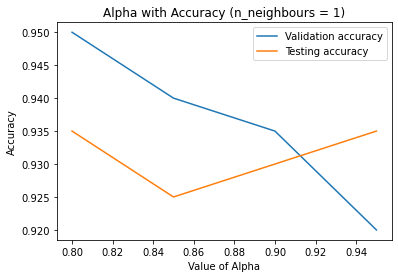

In [ ]:
Alpha = [0.8,0.85,0.9,0.95]
trainning_accuracy,test_accuracy = pca(D_train,Y_train,D_test,Y_test,Alpha)


plt.plot(Alpha, trainning_accuracy, label = "Validation accuracy")
plt.plot(Alpha, test_accuracy, label = "Testing accuracy")
plt.title('Alpha with Accuracy (n_neighbours = 1)')
plt.xlabel("Value of Alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



# **Tunning**

## Method to tune alpha and Knn neighbours

In [ ]:
def pca_tunning(D_train,Y_train,D_test,Y_test,alpha,KNN):
  #compute mean
  mean = np.mean(D_train , axis = 0)

  #center the data
  Z=D_train-mean

  #compute covariance matrix
  rows, columns = D_train.shape
  cov = (1/rows)*np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(cov)
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  trainning_accuracy=np.empty((0,len(KNN)))
  best_model = KNeighborsClassifier(n_neighbors=1)
  best_accuracy=0
  best_reduced_D_test=[]
  best_alpha=0
  best_K=0
  #for every alpha
  skf = StratifiedKFold(n_splits=5)
  for a in alpha:
    print("Alpha: "+str(a))
    #compute the fraction of total variance and choose dimentionality
    sum_lamda=0
    no_of_components=0
    total_lamda=sum(sorted_eigenvalue)
    for i in range(len(sorted_eigenvalue)) :
      sum_lamda=sum_lamda+sorted_eigenvalue[i]
      fraction = sum_lamda/total_lamda
      if(fraction>=a):
        no_of_components=i+1
        break

    print("No.of components"+str(no_of_components))
    #projection matrix
    P=sorted_eigenvectors[:,0:no_of_components]
    print("shape of Projection matrix"+str(P.shape))

    #Project the training set, and test sets
    reduced_D_train = np.dot(D_train,P)
    reduced_D_test = np.dot(D_test,P)

    #find the best n-neighbours 
    train_acc=[]
    for n in KNN:
      knn = KNeighborsClassifier(n_neighbors=n)
      knn.fit(reduced_D_train, np.ravel(Y_train))
      scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
      training_acc = scores.mean()
      train_acc.append(training_acc)
      if training_acc>best_accuracy:
        best_accuracy=training_acc
        best_model=knn
        best_reduced_D_test=reduced_D_test
        best_alpha=a
        best_K=n

    trainning_accuracy=np.vstack((trainning_accuracy,train_acc))
    
  #plot the trainning accuracy with alpha and K
  plot(trainning_accuracy,alpha,KNN)

  #Get best alpha and K 
  print("The Best Validation Accuracy: "+str(best_accuracy))
  print("The Best Alpha: "+str(best_alpha))
  print("The Best n-neighbours: "+str(best_K))
  Y_pred = best_model.predict(best_reduced_D_test)
  accuracy =accuracy_score(np.ravel(Y_test), Y_pred)
  print("Test accuracy with best alpha and n-neighbours : "+str(accuracy))
  

In [ ]:
def plot(trainning_accuracy,alpha,K):
  for n in range(len(K)):
    plt.plot(Alpha, trainning_accuracy[:,n] ,label = "K="+str(K[n]))
  
  plt.title('The performance measure against alpha and K')
  plt.xlabel("Value of Alpha")
  plt.ylabel("Validation Accuracy")
  plt.legend()
  plt.show()


Tunning n_neighbours with respect to the best alpha

Alpha: 0.8
No.of components37
shape of Projection matrix(10304, 37)
Alpha: 0.85
No.of components53
shape of Projection matrix(10304, 53)
Alpha: 0.9
No.of components77
shape of Projection matrix(10304, 77)
Alpha: 0.95
No.of components116
shape of Projection matrix(10304, 116)


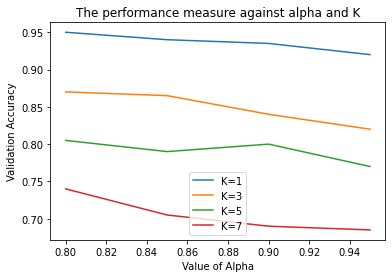

The Best Validation Accuracy: 0.9499999999999998
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.935


In [ ]:
Alpha = [0.8,0.85,0.9,0.95]
K=[1,3,5,7]
pca_tunning(D_train,Y_train,D_test,Y_test,Alpha,K)

# **LDA**

In [ ]:
def LDA(D_train,Y_train,D_test,Y_test):

  #compute mean for every class
  Mean=np.zeros((0, 10304))
  for x in range(0,40):
    m = np.mean(D_train[(Y_train==(x+1)).flatten()], axis=0)
    Mean=np.vstack((Mean,m))

  #compute the Sb
  overallMean=np.mean(D_train,axis=0)
  part_of_data=D_train[(Y_train==1).flatten()]
  row,col = part_of_data.shape
  M=Mean-overallMean
  Sb= row*np.dot(np.transpose(M),M)

  #compute S
  S= np.zeros((10304,10304))
  for i in range(0,40):
    Z=D_train[(Y_train==(i+1)).flatten()]-Mean[i]
    S+=np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  P= sorted_eigenvectors[:,0:39]

  #Project the training set, and test sets
  reduced_D_train = np.dot(D_train,P)
  reduced_D_test = np.dot(D_test,P)

  #K-NN
  skf = StratifiedKFold(n_splits=5)
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(reduced_D_train, np.ravel(Y_train))
  #training_acc = knn.score(reduced_D_train,  np.ravel(Y_train))
  scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
  training_acc = scores.mean()
  test_acc = knn.score(reduced_D_test, np.ravel(Y_test))
  print("Validation Accuracy in LDA: "+str(training_acc))
  print("Testing Accuracy in LDA: "+str(test_acc))



In [ ]:
LDA(D_train,Y_train,D_test,Y_test)

Validation Accuracy in LDA: 0.945
Testing Accuracy in LDA: 0.925


## **Tunning in LDA**

In [ ]:
def LDA_tunning(D_train,Y_train,D_test,Y_test,K):

  #compute mean for every class
  Mean=np.zeros((0, 10304))
  for x in range(0,40):
    m = np.mean(D_train[(Y_train==(x+1)).flatten()], axis=0)
    Mean=np.vstack((Mean,m))

  #compute the Sb
  overallMean=np.mean(D_train,axis=0)
  part_of_data=D_train[(Y_train==1).flatten()]
  row,col = part_of_data.shape
  M=Mean-overallMean
  Sb= row*np.dot(np.transpose(M),M)

  #compute S
  S= np.zeros((10304,10304))
  for i in range(0,40):
    Z=D_train[(Y_train==(i+1)).flatten()]-Mean[i]
    S+=np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  P= sorted_eigenvectors[:,0:39]

  #Project the training set, and test sets
  reduced_D_train = np.dot(D_train,P)
  reduced_D_test = np.dot(D_test,P)

  #K-NN
  best_model=KNeighborsClassifier(n_neighbors=1) 
  best_accuracy=0
  best_K=0
  train_acc=[]
  skf = StratifiedKFold(n_splits=5)
  for n in K:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(reduced_D_train, np.ravel(Y_train))
    scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
    training_acc = scores.mean()
    train_acc.append(training_acc)
    if training_acc>best_accuracy:
      best_accuracy=training_acc
      best_model=knn
      best_K=n

  #plot K with trainning accuracy
  fig, ax = plt.subplots()
  ax.plot(K, train_acc)
  plt.title('Knn with Validation Accuracy')
  plt.xlabel("Value of n-neighbours")
  plt.ylabel("Validation Accuracy")
  plt.show()

  print("The best Validation accuracy = "+str(best_accuracy))
  print("The best n-neighbours = "+str(best_K))

  Y_pred = best_model.predict(reduced_D_test)
  accuracy =accuracy_score(np.ravel(Y_test), Y_pred)
  print("Test accuracy with the best n-neighbours : "+str(accuracy))

  



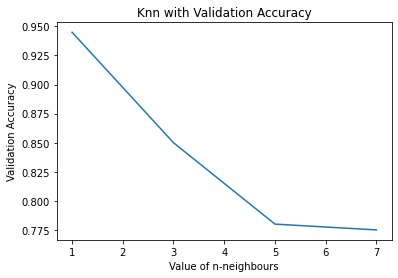

The best Validation accuracy = 0.945
The best n-neighbours = 1
Test accuracy with the best n-neighbours : 0.925


In [ ]:
K=[1,3,5,7]
train_acc = LDA_tunning(D_train,Y_train,D_test,Y_test,K)

# **Read non-face images**

label of faces = 1
label of non_faces = 0

In [ ]:
Data_non_faces=np.empty((0,10304),dtype=int)
label_non_faces=np.empty((0,1),dtype=int)

In [ ]:
def read_non_faces_from_folder(n ,path):
  counter=0
  label = 0
  newsize = (92, 112)
  global Data_non_faces
  global label_non_faces
  for pic in os.listdir(path):
      img=cv2.imread(os.path.join(path,pic),0)
      img2 = cv2.resize(img, newsize)
      #cv2_imshow(img2)
      data = asarray(img2).flatten()
      Data_non_faces=np.vstack((Data_non_faces,data))
      label_non_faces=np.vstack((label_non_faces,label))
      counter+=1
      if counter ==n:
        break;


def read_non_faces(total_number):
  n=total_number/7
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/car')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/cat')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/dog')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/flower')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/fruit')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/airplane')
  read_non_faces_from_folder(n ,'/content/drive/MyDrive/kaggle_dataset/non-face-images/data/natural_images/motorbike')


# **Classification of non-face data using PCA**

In [ ]:
def pca_non_faces(D_train,Y_train,D_test,Y_test,alpha,KNN):
  #compute mean
  mean = np.mean(D_train , axis = 0)

  #center the data
  Z=D_train-mean

  #compute covariance matrix
  rows, columns = D_train.shape
  cov = (1/rows)*np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(cov)
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  trainning_accuracy=np.empty((0,len(KNN)))
  best_model = KNeighborsClassifier(n_neighbors=1)
  best_accuracy=0
  best_reduced_D_test=[]
  best_alpha=0
  best_K=0
  #for every alpha
  skf = StratifiedKFold(n_splits=5)
  for a in alpha:
    #print("Alpha: "+str(a))
    #compute the fraction of total variance and choose dimentionality
    sum_lamda=0
    no_of_components=0
    total_lamda=sum(sorted_eigenvalue)
    for i in range(len(sorted_eigenvalue)) :
      sum_lamda=sum_lamda+sorted_eigenvalue[i]
      fraction = sum_lamda/total_lamda
      if(fraction>=a):
        no_of_components=i+1
        break

    #print("No.of components"+str(no_of_components))
    #projection matrix
    P=sorted_eigenvectors[:,0:no_of_components]
    #print("shape of Projection matrix"+str(P.shape))

    #Project the training set, and test sets
    reduced_D_train = np.dot(D_train,P)
    reduced_D_test = np.dot(D_test,P)

    #find the best n-neighbours 
    train_acc=[]
    for n in KNN:
      knn = KNeighborsClassifier(n_neighbors=n)
      knn.fit(reduced_D_train, np.ravel(Y_train))
      scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
      training_acc = scores.mean()
      train_acc.append(training_acc)
      if training_acc>best_accuracy:
        best_accuracy=training_acc
        best_model=knn
        best_reduced_D_test=reduced_D_test
        best_alpha=a
        best_K=n

    trainning_accuracy=np.vstack((trainning_accuracy,train_acc))
    
  #Get best alpha and K 
  print("The Best Trainning Accuracy: "+str(best_accuracy))
  print("The Best Alpha: "+str(best_alpha))
  print("The Best n-neighbours: "+str(best_K))
  Y_pred = best_model.predict(best_reduced_D_test)
  accuracy =accuracy_score(np.ravel(Y_test), Y_pred)
  print("Test accuracy with best alpha and n-neighbours : "+str(accuracy))

  return best_accuracy , accuracy , Y_pred

The number of non face images : 210
The Best Trainning Accuracy: 0.9049180327868853
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9049180327868852
The number of non face images : 840
The Best Trainning Accuracy: 0.9338709677419355
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9290322580645162
The number of non face images : 1680
The Best Trainning Accuracy: 0.95
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9471153846153846
The number of non face images : 3360
The Best Trainning Accuracy: 0.9611702127659575
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9686170212765958
The number of non face images : 4914
The Best Trainning Accuracy: 0.9698851648896252
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9702672186676703


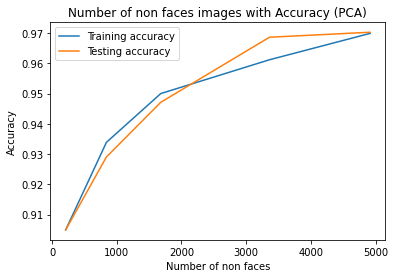

In [ ]:
No_of_non_faces=[210 , 840 , 1680 , 3360 , 4914]
Alpha=[0.8,0.85,0.9,0.95]
K=[1,3,5,7]
training_accuracy = []
testing_accuracy = []
for n in No_of_non_faces:
  print("The number of non face images : "+str(n))
  Data_non_faces=np.empty((0,10304),dtype=int)
  label_non_faces=np.empty((0,1),dtype=int)
  #read non face images
  read_non_faces(n)

  #split non face image
  Data_non_faces_train = Data_non_faces[::2, :]
  label_non_faces_train = label_non_faces[::2, :]
  Data_non_faces_test = Data_non_faces[1::2, :]
  label_non_faces_test = label_non_faces[1::2, :]

  ###combine faces and non faces####

  #combine Data_non_faces_train with D_train
  Data_train=np.concatenate((Data_non_faces_train, D_train), axis=0)
  #generate label of faces (train)
  label_of_faces_train=np.ones((200,1),dtype=int)
  #combine label of non-faces and faces (train)
  Label_train=np.concatenate((label_non_faces_train, label_of_faces_train), axis=0)

  #combine Data_non_faces_test with D_test
  Data_test=np.concatenate((Data_non_faces_test, D_test), axis=0)
  #generate label of faces (test)
  label_of_faces_test=np.ones((200,1),dtype=int)
  #combine label of non-faces and faces (test)
  Label_test=np.concatenate((label_non_faces_test, label_of_faces_test), axis=0)

  ##shuffle 
  Data_label_train = np.concatenate((Data_train, Label_train), axis=1)
  Data_label_test = np.concatenate((Data_test, Label_test), axis=1)

  np.random.shuffle(Data_label_train)
  np.random.shuffle(Data_label_test)

  Data_train = Data_label_train[:,0:10304]
  Label_train = Data_label_train[:,[-1]]
  Data_test = Data_label_test[:,0:10304]
  Label_test = Data_label_test[:,[-1]]


  ##PCA
  train_acc , test_acc , Label_predicted = pca_non_faces(Data_train,Label_train,Data_test,Label_test,Alpha,K)
  training_accuracy.append(train_acc)
  testing_accuracy.append(test_acc)


#plot training and testing accuracy vs number of non face images
plt.plot(No_of_non_faces, training_accuracy, label = "Training accuracy")
plt.plot(No_of_non_faces, testing_accuracy, label = "Testing accuracy")
plt.title('Number of non faces images with Accuracy (PCA)')
plt.xlabel("Number of non faces")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# **Classification of non-faces data using LDA**

In [ ]:
def LDA_non_faces(D_train,Y_train,D_test,Y_test,K):

  #compute mean for every class
  Mean=np.zeros((0, 10304))
  for x in range(0,2):
    m = np.mean(D_train[(Y_train==(x)).flatten()], axis=0)
    Mean=np.vstack((Mean,m))

  #compute the Sb
  overallMean=np.mean(D_train,axis=0)
  part_of_data=D_train[(Y_train==1).flatten()]
  row,col = part_of_data.shape
  M=Mean-overallMean
  Sb= row*np.dot(np.transpose(M),M)

  #compute S
  S= np.zeros((10304,10304))
  for i in range(0,2):
    Z=D_train[(Y_train==(i)).flatten()]-Mean[i]
    S+=np.dot(np.transpose(Z),Z)

  #compute and sort descendingly eigenvalues and eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))
  
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  P= sorted_eigenvectors[:,[0]]

  #Project the training set, and test sets
  reduced_D_train = np.dot(D_train,P)
  reduced_D_test = np.dot(D_test,P)

  #K-NN
  best_model=KNeighborsClassifier(n_neighbors=1) 
  best_accuracy=0
  best_K=0
  train_acc=[]
  skf = StratifiedKFold(n_splits=5)
  for n in K:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(reduced_D_train, np.ravel(Y_train))
    scores = cross_val_score(knn, reduced_D_train, np.ravel(Y_train), cv=skf, scoring='accuracy')
    training_acc = scores.mean()
    train_acc.append(training_acc)
    if training_acc>best_accuracy:
      best_accuracy=training_acc
      best_model=knn
      best_K=n

  print("The best Validation accuracy = "+str(best_accuracy))
  print("The best n-neighbours = "+str(best_K))

  Y_pred = best_model.predict(reduced_D_test)
  accuracy =accuracy_score(np.ravel(Y_test), Y_pred)
  print("Test accuracy with the best n-neighbours : "+str(accuracy))

  return best_accuracy , accuracy , Y_pred

  

The number of non face images : 210
The best Validation accuracy = 0.8655737704918032
The best n-neighbours = 3
Test accuracy with the best n-neighbours : 0.8524590163934426
The number of non face images : 840
The best Validation accuracy = 0.7725806451612904
The best n-neighbours = 3
Test accuracy with the best n-neighbours : 0.7564516129032258
The number of non face images : 1680
The best Validation accuracy = 0.8365384615384615
The best n-neighbours = 7
Test accuracy with the best n-neighbours : 0.8259615384615384
The number of non face images : 3360
The best Validation accuracy = 0.9005319148936171
The best n-neighbours = 7
Test accuracy with the best n-neighbours : 0.8845744680851064
The number of non face images : 4914
The best Validation accuracy = 0.9269848349687779
The best n-neighbours = 7
Test accuracy with the best n-neighbours : 0.9179525780955965


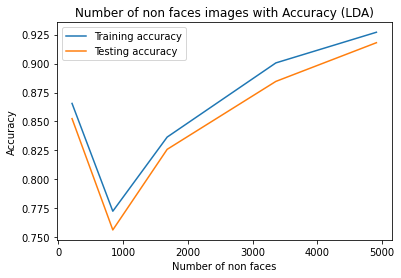

In [ ]:
No_of_non_faces=[210 , 840 , 1680 , 3360 , 4914]
K=[1,3,5,7]
training_accuracy = []
testing_accuracy = []
for n in No_of_non_faces:
  print("The number of non face images : "+str(n))
  Data_non_faces=np.empty((0,10304),dtype=int)
  label_non_faces=np.empty((0,1),dtype=int)
  #read non face images
  read_non_faces(n)

  #split non face image
  Data_non_faces_train = Data_non_faces[::2, :]
  label_non_faces_train = label_non_faces[::2, :]
  Data_non_faces_test = Data_non_faces[1::2, :]
  label_non_faces_test = label_non_faces[1::2, :]

  ###combine faces and non faces####

  #combine Data_non_faces_train with D_train
  Data_train=np.concatenate((Data_non_faces_train, D_train), axis=0)
  #generate label of faces (train)
  label_of_faces_train=np.ones((200,1),dtype=int)
  #combine label of non-faces and faces (train)
  Label_train=np.concatenate((label_non_faces_train, label_of_faces_train), axis=0)

  #combine Data_non_faces_test with D_test
  Data_test=np.concatenate((Data_non_faces_test, D_test), axis=0)
  #generate label of faces (test)
  label_of_faces_test=np.ones((200,1),dtype=int)
  #combine label of non-faces and faces (test)
  Label_test=np.concatenate((label_non_faces_test, label_of_faces_test), axis=0)

  ##shuffle 
  Data_label_train = np.concatenate((Data_train, Label_train), axis=1)
  Data_label_test = np.concatenate((Data_test, Label_test), axis=1)

  np.random.shuffle(Data_label_train)
  np.random.shuffle(Data_label_test)

  Data_train = Data_label_train[:,0:10304]
  Label_train = Data_label_train[:,[-1]]
  Data_test = Data_label_test[:,0:10304]
  Label_test = Data_label_test[:,[-1]]


  ##LDA
  train_acc , test_acc , Label_predicted = LDA_non_faces(Data_train,Label_train,Data_test,Label_test,K)
  training_accuracy.append(train_acc)
  testing_accuracy.append(test_acc)


#plot training and testing accuracy vs number of non face images
plt.plot(No_of_non_faces, training_accuracy, label = "Training accuracy")
plt.plot(No_of_non_faces, testing_accuracy, label = "Testing accuracy")
plt.title('Number of non faces images with Accuracy (LDA)')
plt.xlabel("Number of non faces")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# **Show failure and success cases**

## PCA

In [ ]:
Alpha=[0.8,0.85,0.9,0.95]
K=[1,3,5,7]
Data_non_faces=np.empty((0,10304),dtype=int)
label_non_faces=np.empty((0,1),dtype=int)
#read non face images
read_non_faces(420)

#split non face image
Data_non_faces_train = Data_non_faces[::2, :]
label_non_faces_train = label_non_faces[::2, :]
Data_non_faces_test = Data_non_faces[1::2, :]
label_non_faces_test = label_non_faces[1::2, :]

###combine faces and non faces####

#combine Data_non_faces_train with D_train
Data_train=np.concatenate((Data_non_faces_train, D_train), axis=0)
#generate label of faces (train)
label_of_faces_train=np.ones((200,1),dtype=int)
#combine label of non-faces and faces (train)
Label_train=np.concatenate((label_non_faces_train, label_of_faces_train), axis=0)

#combine Data_non_faces_test with D_test
Data_test=np.concatenate((Data_non_faces_test, D_test), axis=0)
#generate label of faces (test)
label_of_faces_test=np.ones((200,1),dtype=int)
#combine label of non-faces and faces (test)
Label_test=np.concatenate((label_non_faces_test, label_of_faces_test), axis=0)

##shuffle 
Data_label_train = np.concatenate((Data_train, Label_train), axis=1)
Data_label_test = np.concatenate((Data_test, Label_test), axis=1)

np.random.shuffle(Data_label_train)
np.random.shuffle(Data_label_test)

Data_train = Data_label_train[:,0:10304]
Label_train = Data_label_train[:,[-1]]
Data_test = Data_label_test[:,0:10304]
Label_test = Data_label_test[:,[-1]]


In [ ]:
##PCA
train_acc , test_acc , Label_predicted = pca_non_faces(Data_train,Label_train,Data_test,Label_test,Alpha,K)
print("Validation accuracy : "+str(train_acc))
print("Testing accuracy : "+str(test_acc))

#compare Y_predicted with Label_test
Label_test = np.ravel(Label_test)

The Best Trainning Accuracy: 0.9195121951219513
The Best Alpha: 0.8
The Best n-neighbours: 1
Test accuracy with best alpha and n-neighbours : 0.9048780487804878
Validation accuracy : 0.9195121951219513
Testing accuracy : 0.9048780487804878


Failure


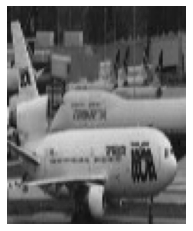

Failure


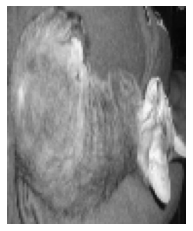

Failure


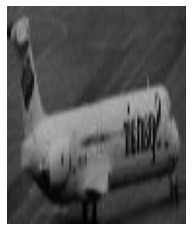

Failure


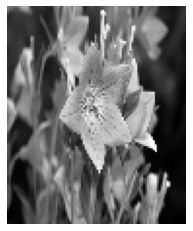

Failure


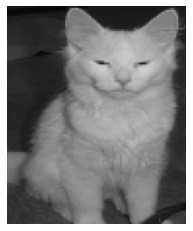

Failure


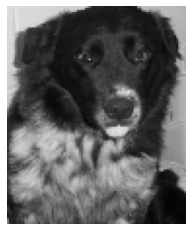

Failure


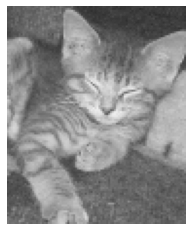

Failure


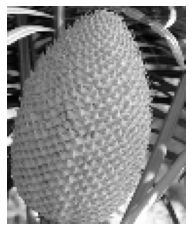

Failure


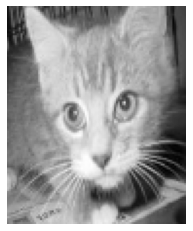

Failure


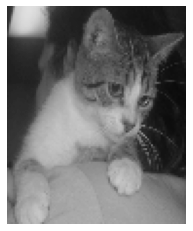

Failure


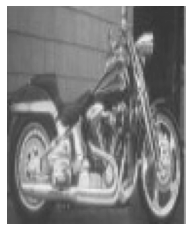

Failure


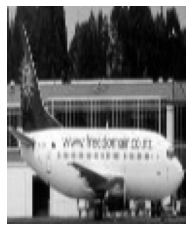

Failure


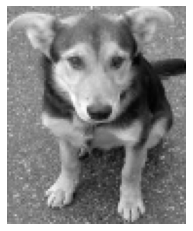

Failure


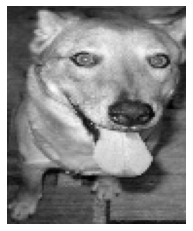

Failure


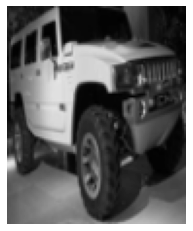

Failure


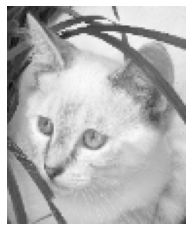

Failure


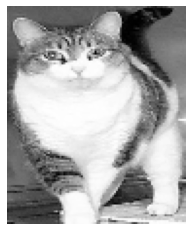

Failure


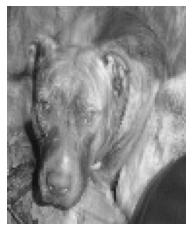

Failure


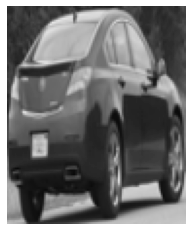

Failure


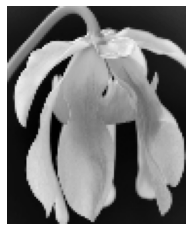

Failure


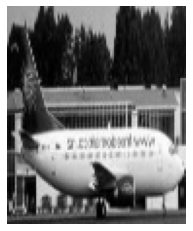

Failure


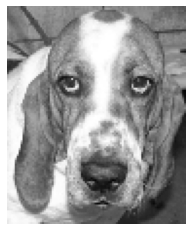

Failure


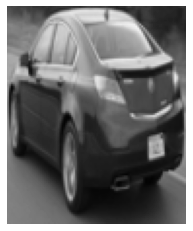

Failure


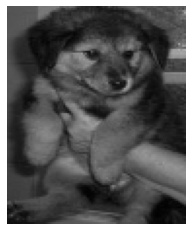

Failure


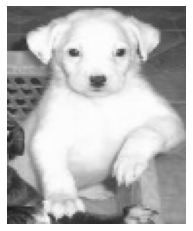

Failure


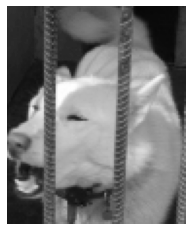

Failure


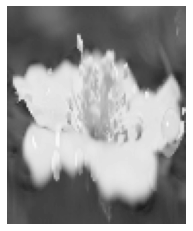

Failure


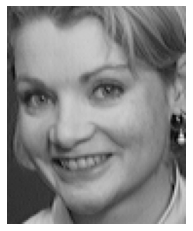

Failure


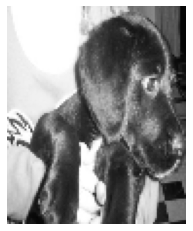

Failure


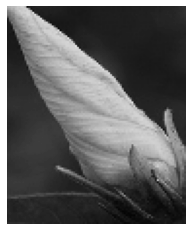

Failure


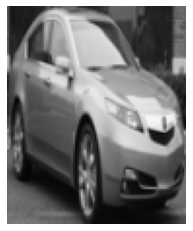

Failure


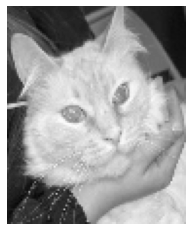

Failure


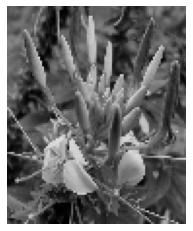

Failure


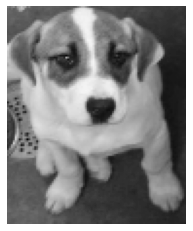

Failure


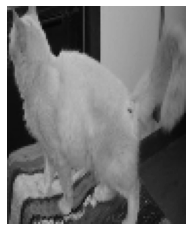

Failure


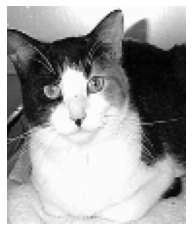

Failure


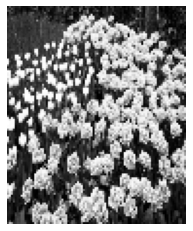

Failure


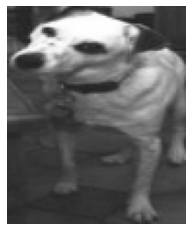

Failure


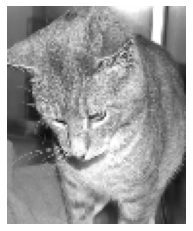

In [ ]:
for i in range(len(Label_test)):
  if(Label_test[i]!=Label_predicted[i]):
    print("Failure")
    img=Data_test[i]
    plt.imshow(img.reshape((112,92)),cmap='gray', vmin = 0, vmax = 255)
    plt.axis('off')
    plt.show()
  

## LDA

In [ ]:
##LDA
train_acc , test_acc , Label_predicted = LDA_non_faces(Data_train,Label_train,Data_test,Label_test,K)
print("Validation accuracy : "+str(train_acc))
print("Testing accuracy : "+str(test_acc))

#compare Y_predicted with Label_test
Label_test = np.ravel(Label_test)

The best Validation accuracy = 0.8048780487804879
The best n-neighbours = 7
Test accuracy with the best n-neighbours : 0.8317073170731707
Validation accuracy : 0.8048780487804879
Testing accuracy : 0.8317073170731707


Failure


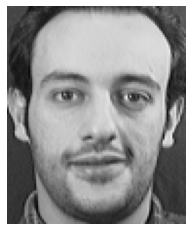

Failure


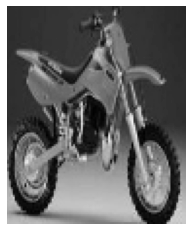

Failure


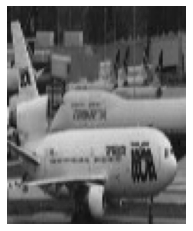

Failure


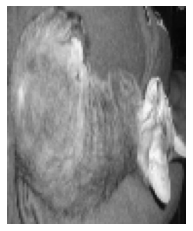

Failure


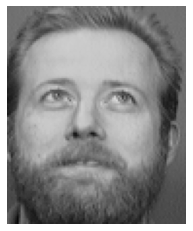

Failure


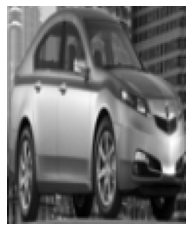

Failure


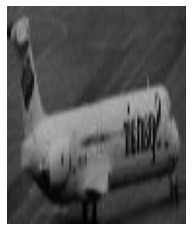

Failure


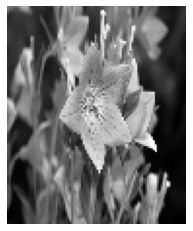

Failure


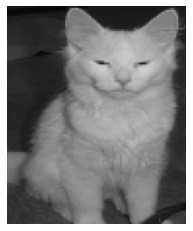

Failure


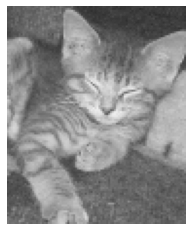

Failure


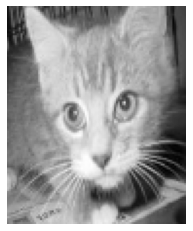

Failure


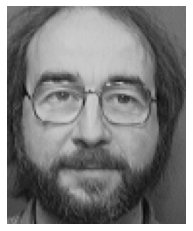

Failure


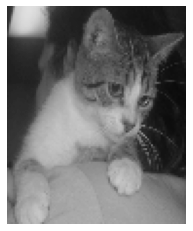

Failure


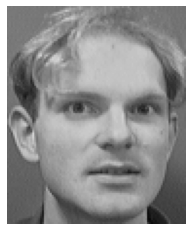

Failure


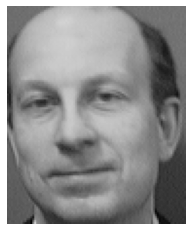

Failure


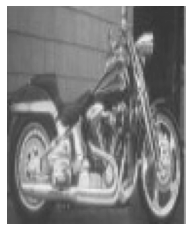

Failure


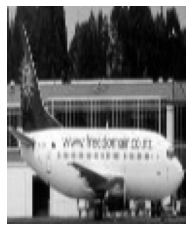

Failure


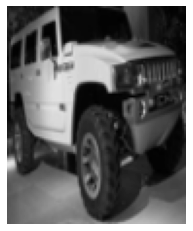

Failure


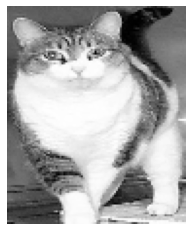

Failure


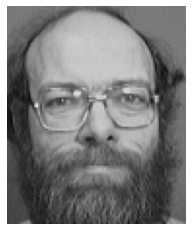

Failure


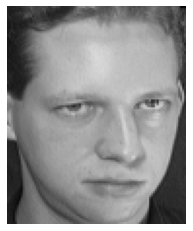

Failure


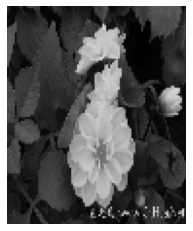

Failure


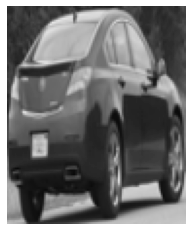

Failure


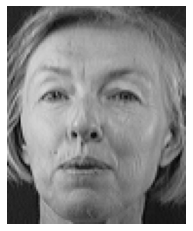

Failure


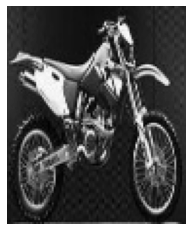

Failure


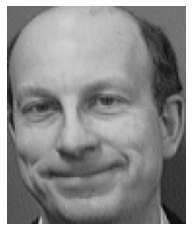

Failure


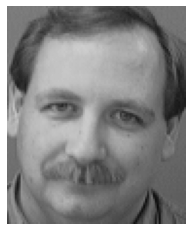

Failure


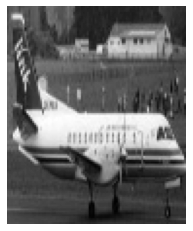

Failure


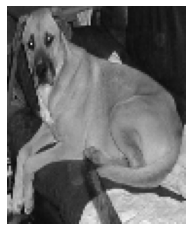

Failure


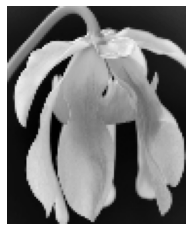

Failure


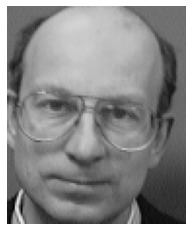

Failure


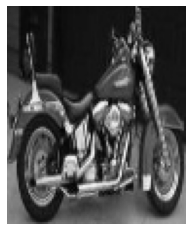

Failure


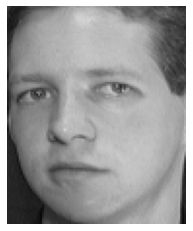

Failure


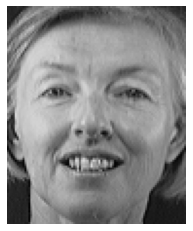

Failure


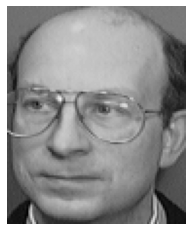

Failure


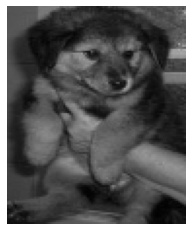

Failure


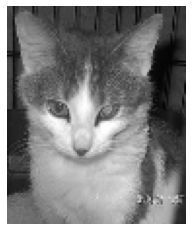

Failure


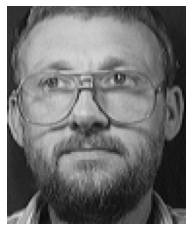

Failure


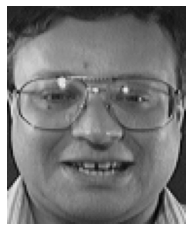

Failure


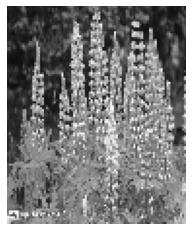

Failure


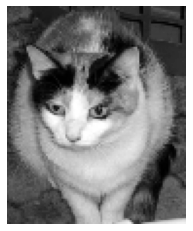

Failure


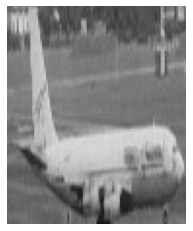

Failure


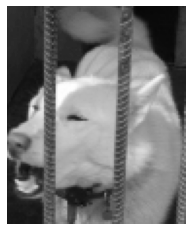

Failure


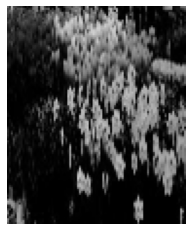

Failure


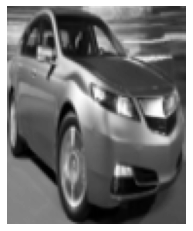

Failure


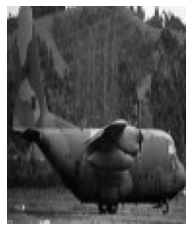

Failure


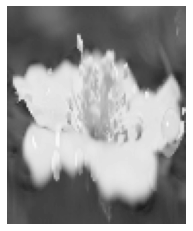

Failure


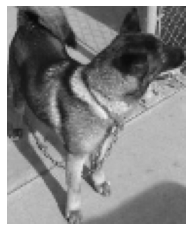

Failure


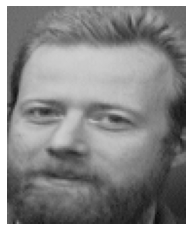

Failure


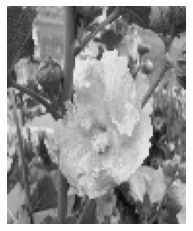

Failure


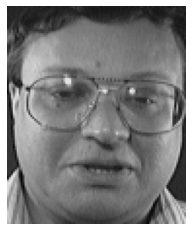

Failure


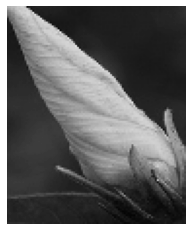

Failure


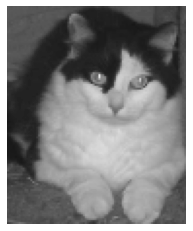

Failure


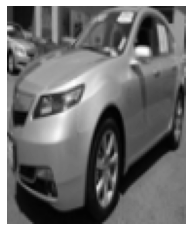

Failure


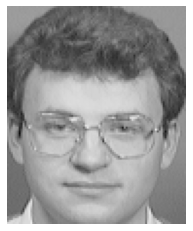

Failure


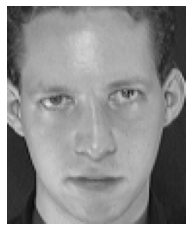

Failure


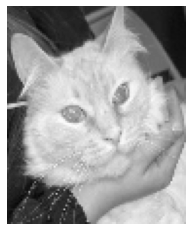

Failure


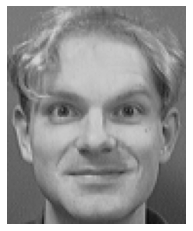

Failure


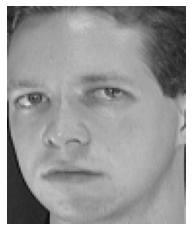

Failure


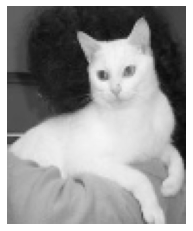

Failure


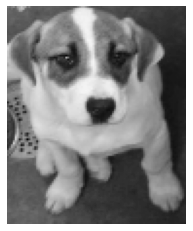

Failure


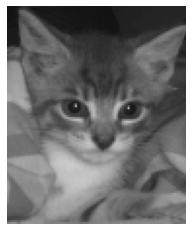

Failure


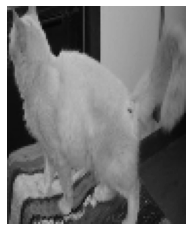

Failure


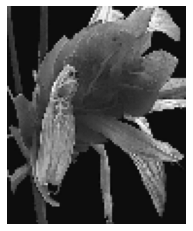

Failure


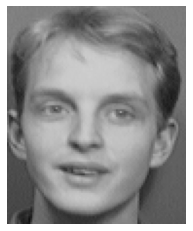

Failure


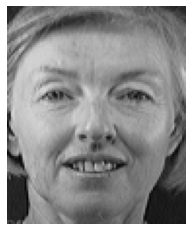

Failure


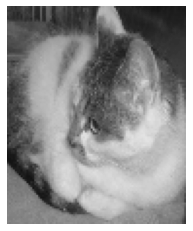

Failure


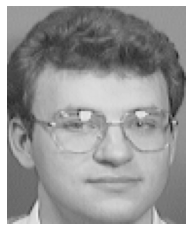

Failure


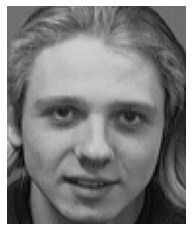

In [ ]:
for i in range(len(Label_test)):
  if(Label_test[i]!=Label_predicted[i]):
    print("Failure")
    img=Data_test[i]
    plt.imshow(img.reshape((112,92)),cmap='gray', vmin = 0, vmax = 255)
    plt.axis('off')
    plt.show()
